# 目的

学習した機械学習器の学習・予測データの予測に寄与した特徴量を可視化する

## 機械学習モデルの解釈
SHAPによって、入出力値から、出力に寄与した特徴量をSHAP値で表現できる。  
しかし、前処理でPCAを実施しているため、SHAPで出力される特徴量はPCAのままである。  
このままでは出力に寄与した遺伝子名（生の特徴量）がわからないため、PCAのloading（因子負荷量：主成分と元の特徴量を標準化した変数の相関係数）をSHAPの平均絶対値と内積をとってordinal score：順序スコアを定義する。


In [3]:
# 基本的なライブラリ
import warnings
from tqdm import tqdm

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# パイプライン（imblearn）
from imblearn.pipeline import Pipeline
from imblearn import FunctionSampler

from sksurv.ensemble import (
    ComponentwiseGradientBoostingSurvivalAnalysis,
    GradientBoostingSurvivalAnalysis,
    RandomSurvivalForest,
    ExtraSurvivalTrees,
)
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.tree import SurvivalTree

# XAI
import shap

# config python file
import config
import functions

SEED = config.SEED
TARGET_NAME = ["RFS_STATUS", "RFS_MONTHS"]
functions.fix_seed(SEED)


df_recurrenced = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/df_recurrenced4numeric.pkl"
)

ImportError: cannot import name '_any_isnan_axis0' from 'sklearn.tree._utils' (/root/miniconda3/lib/python3.8/site-packages/sklearn/tree/_utils.cpython-38-x86_64-linux-gnu.so)

# SHAP

In [5]:
def save_shap_instances(
    shap_explainer: callable,
    shap_values: callable,
    save_file_path: str = ".",
):
    # fit後pipelineの保存
    functions.make_dir(save_file_path)
    functions.dill_dump(shap_explainer, "{0}/shap_explainer.pkl".format(save_file_path))
    functions.dill_dump(shap_values, "{0}/shap_values.pkl".format(save_file_path))

In [6]:
def explain_model(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.explainers.Permutation(
        _estimator.predict, _X, max_evals="auto", seed=config.SEED
    )
    """
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        seed=config.SEED,
    )"""
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

In [7]:
def explain_model2(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.explainers.Permutation(
        _estimator.predict, _X, max_evals="auto", seed=config.SEED
    )
    """
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        seed=config.SEED,
    )"""
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

In [8]:
## 全体での実行

In [9]:
# 層別化する特徴量
def exec_shap(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path: ", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

# ランキングの作成

## shap値の取得+pcaを利用した計算

In [10]:
def calc_score(
    model_order_dict: dict(),
) -> pd.DataFrame():
#subgroup_path = "./{0}/{1}/{2}"の./←消す！消さなくてもいけるかも？
    subgroup_path = "{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    shap.plots.beeswarm(sv)
    
    #shap.summary_plot(sv,plot_type='bar')
    
    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )

    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )

    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

In [13]:
preprocess_pipeline = functions.pickle_load(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_Incpca216/test_set/test/preprocess_pipeline.pkl"
                                           )
pca = preprocess_pipeline[-1]
pca

IncrementalPCA(n_components=216)

In [194]:
c = pd.read_pickle(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/test/X.pkl"
)
df_pca29 = pd.DataFrame(
    c, columns=pca.get_feature_names_out()
)
display(df_pca29.head())

FileNotFoundError: [Errno 2] No such file or directory: '../data/interim/PREPROCESSED/RECURRENCE/CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/test/X.pkl'

In [195]:
df_gene_expressions = pd.read_pickle(
     config.INTERIM_PREPROCESSED_RECURRENCE_DIR +"/df_gene_expressions.pkl"
)
df_pca29_pca5 = pd.DataFrame(
    pca.components_,
    index=pca.get_feature_names_out(),
    columns=df_gene_expressions.columns,
).T["pca5"].apply(lambda x: abs(x)).sort_values(ascending=False)

df_pca29_pca5 = pd.DataFrame(df_pca29_pca5)
df_pca29_pca5

KeyError: 'pca5'

In [ ]:
 loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        #pca.components_,
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )
l = loadings.T
l_5 = l["pca13"].apply(lambda x: abs(x)).sort_values(ascending=False)
l_5 = pd.DataFrame(l_5)
l_5.rename(columns={'pca13': 'Feature 13'})

In [ ]:
l["pca13"].sort_values(ascending=False)

## 予測で最も性能の高かったパターンでのスコア算出

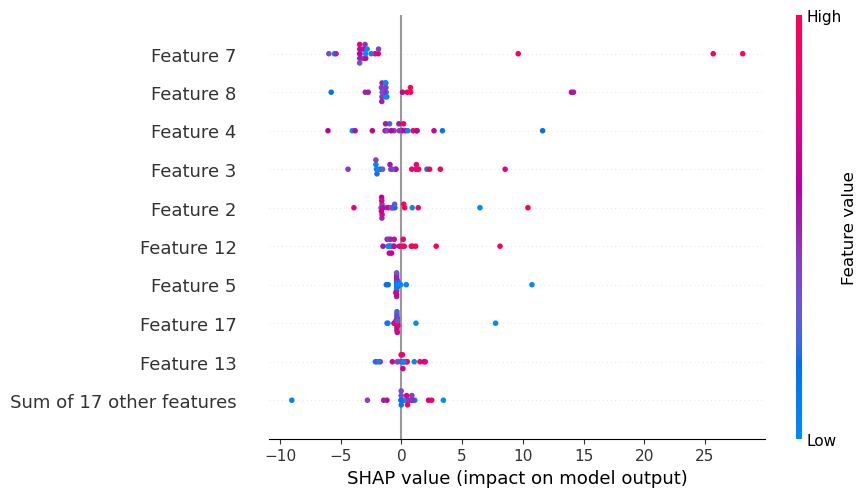

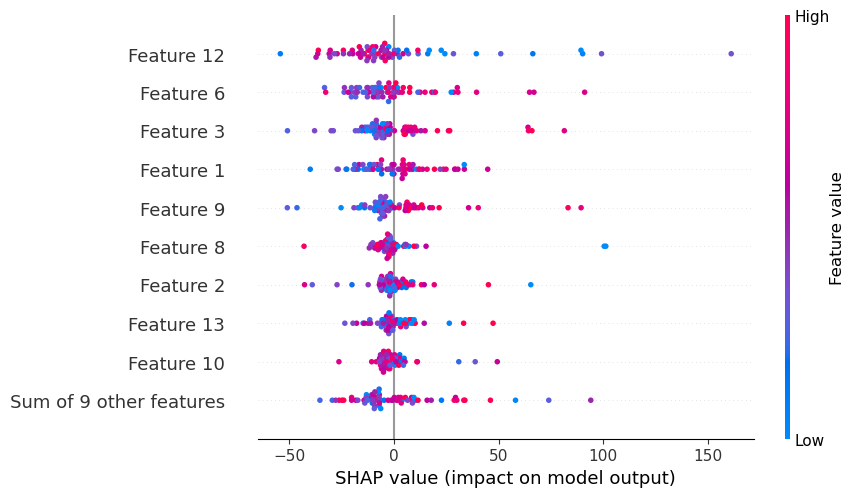

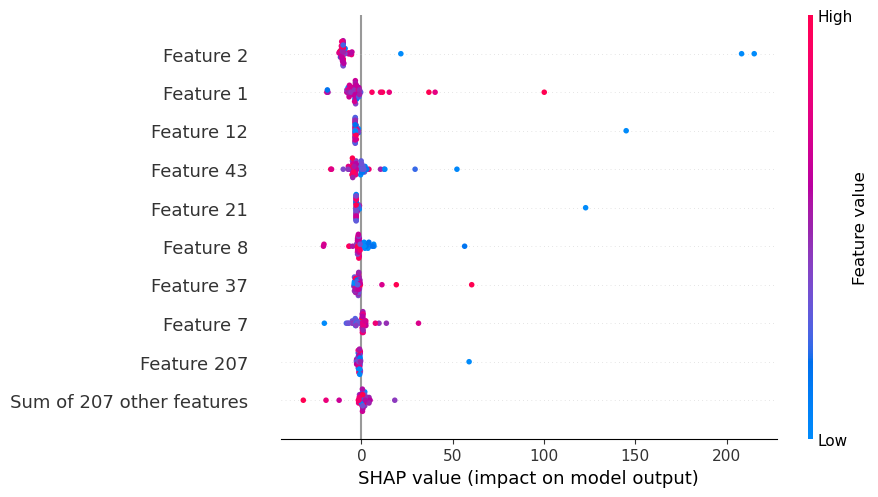

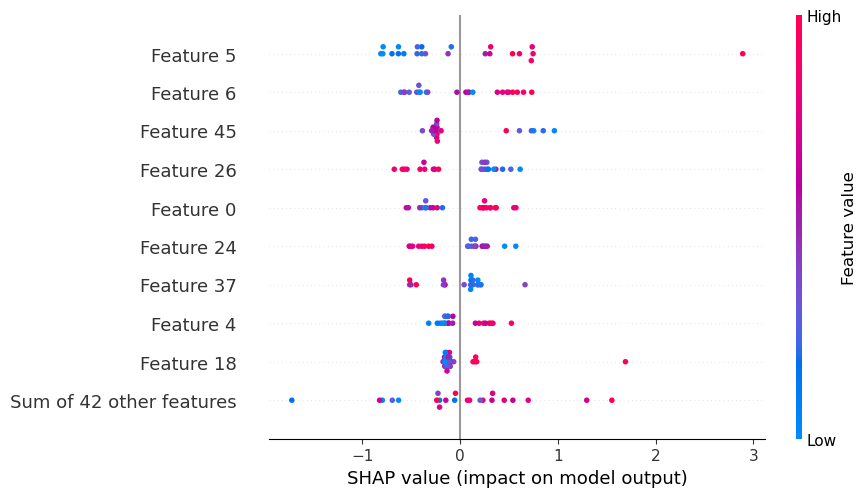

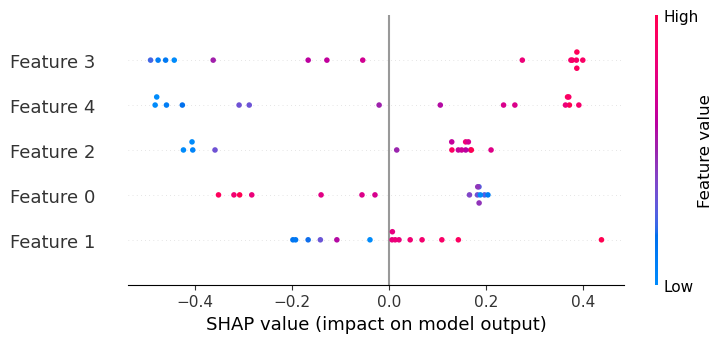

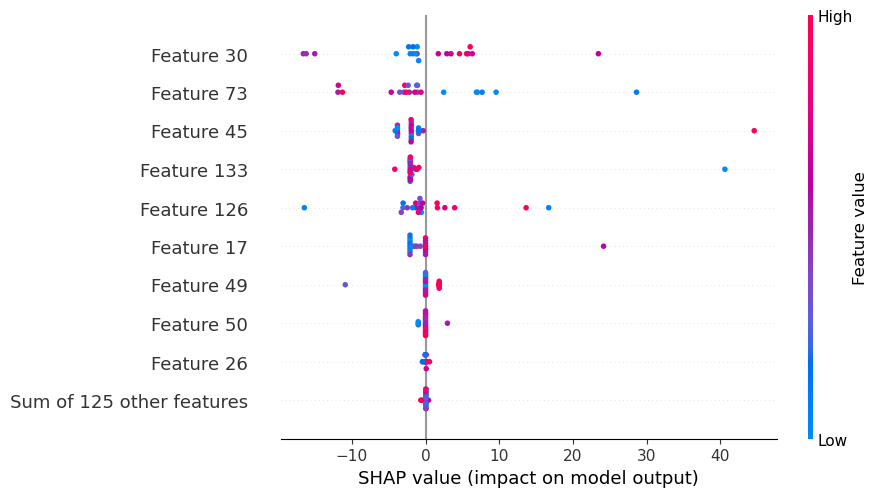

In [14]:
# IncrementalPCA

model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca26",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow = calc_score(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca18",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA = calc_score(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca216",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB = calc_score(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca51",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2 = calc_score(model_order_dict)



model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca5",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal = calc_score(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca134",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}

rank_Basal = calc_score(model_order_dict)


In [46]:
rank_Her2 = rank_Her2.rename(columns={"gene name": "gene_Her2", "score": "score_Her2"})
df_rank = rank_Her2.copy()
df_rank = pd.merge(df_rank, rank_Her2, right_index=True, left_index=True)
df_rank.to_csv("./explain_score.csv")
df_rank

,gene_Her2_x,score_Her2_x,gene_Her2_y,score_Her2_y
0,SYT11,19.067489,SYT11,19.067489
1,GAS7,17.839027,GAS7,17.839027
2,PPP1R18,17.523349,PPP1R18,17.523349
3,RASSF2,17.476976,RASSF2,17.476976
4,TMEM119,17.438570,TMEM119,17.438570
...,...,...,...,...
20598,PLAA,1.564329,PLAA,1.564329
20599,AGBL1,1.546398,AGBL1,1.546398
20600,CDH18,1.530603,CDH18,1.530603
20601,LIMD2,1.496331,LIMD2,1.496331


In [44]:
rank_claudinlow = rank_claudinlow.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA = rank_LumA.rename(columns={"gene name": "gene_LumA", "score": "score_LumA"})
rank_LumB = rank_LumB.rename(columns={"gene name": "gene_LumB", "score": "score_LumB"})
rank_Her2 = rank_Her2.rename(columns={"gene name": "gene_Her2", "score": "score_Her2"})
rank_Basal = rank_Basal.rename(columns={"gene name": "gene_Basal", "score": "Basal"})
rank_Normal = rank_Normal.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank = rank_claudinlow.copy()
df_rank = pd.merge(df_rank, rank_LumA, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_LumB, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Her2, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Normal, right_index=True, left_index=True)
df_rank = pd.merge(df_rank, rank_Basal, right_index=True, left_index=True)
# 一時的な保存
df_rank.to_csv("./explain_score.csv")
df_rank

NameError: name 'rank_claudinlow' is not defined

# 晩期再発者のみの調査

In [55]:
# 層別化する特徴量
def exec_shap4late_recurrences(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/late_recurrences",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

In [259]:
# shap_valueをもとにプロット・保存を実施する関数
def plot_sv(sv):
    plt.figure(figsize=(6, 6))
    shap.plots.beeswarm(sv, show=False)
    plt.title(model_order_dict["subgroup"])
    plt.tight_layout()
    
    functions.make_dir(config.FIGURES_EXPLAIN_RECURRENCE_DIR)
    functions.make_dir("{0}/{1}/{2}/{3}/{4}".format(
        config.FIGURES_EXPLAIN_RECURRENCE_DIR,
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
        model_order_dict["model_name"]
    ))


    # プロットを保存（保存先を指定）
    save_path = "{0}/{1}/{2}/{3}/{4}".format(
        config.FIGURES_EXPLAIN_RECURRENCE_DIR,
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
        model_order_dict["model_name"]
    )

    plt.savefig(save_path + "/shap_{0}.png".format(model_order_dict["subgroup"]))


# 晩期再発者向けに定義した順序スコアを計算するための関数
def calc_score4late_recurrences(
    model_order_dict: dict(),
) -> pd.DataFrame():

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )

    # load shap values
    pkl_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    try:
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")
    except:
        exec_shap4late_recurrences(model_order_dict)
        sv = functions.dill_load(pkl_path + "/shap_values.pkl")

    plot_sv(sv)

    # beeswarm plotに準じたDataFrameの作成
    df_shap = pd.DataFrame(
        sv.abs.mean(0).values, index=sv.feature_names, columns=["shap abs means"]
    )
    df_shap = pd.DataFrame(df_shap)
    # load preprocess pipeline
    pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
    preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
    pca = preprocess_pipeline[-1]

    # 主成分負荷量（loading）の計算
    loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    )
    # shap値の絶対値平均値とloadingの絶対値の積に基づく順序ランキング作成
    scores = pd.DataFrame(
        np.dot(df_shap.T, abs(loadings)), index=["score"], columns=loadings.columns
    ).T
    ranking = scores.sort_values(by="score", ascending=False)
    ranking = ranking.reset_index().rename(columns={"index": "gene name"})
    return ranking

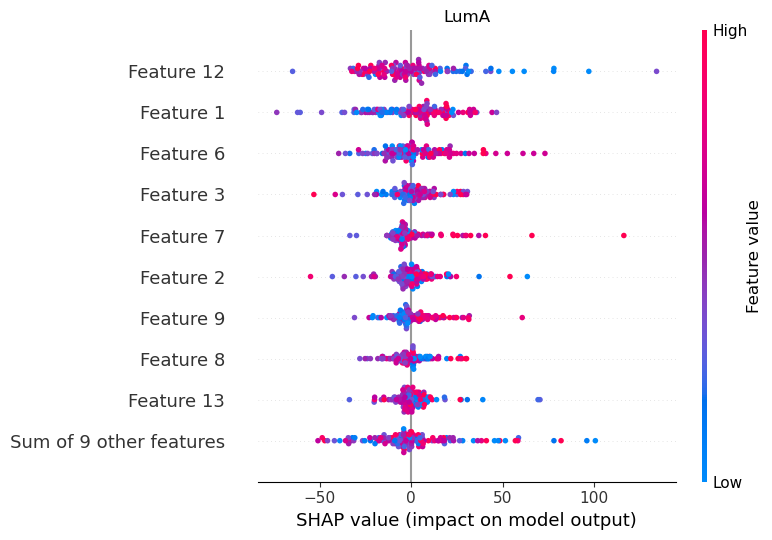

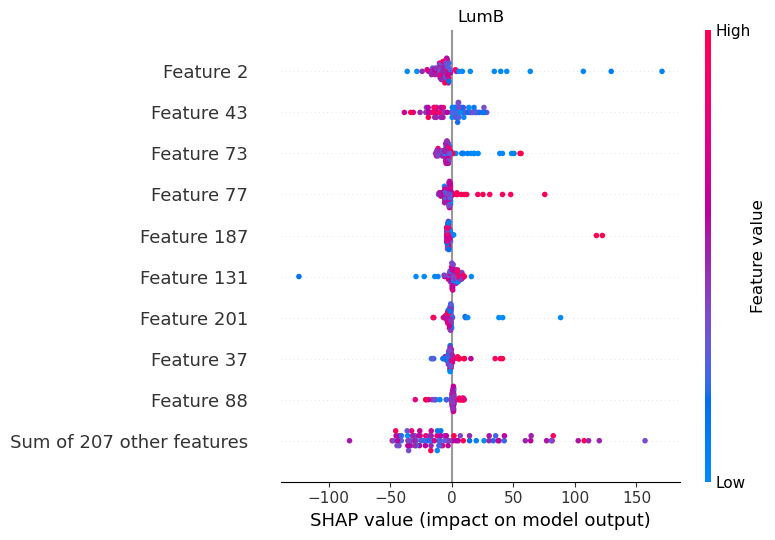

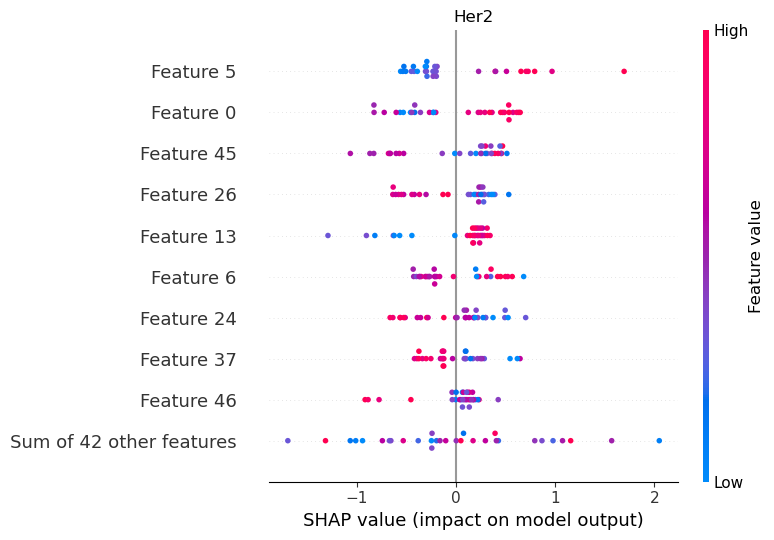

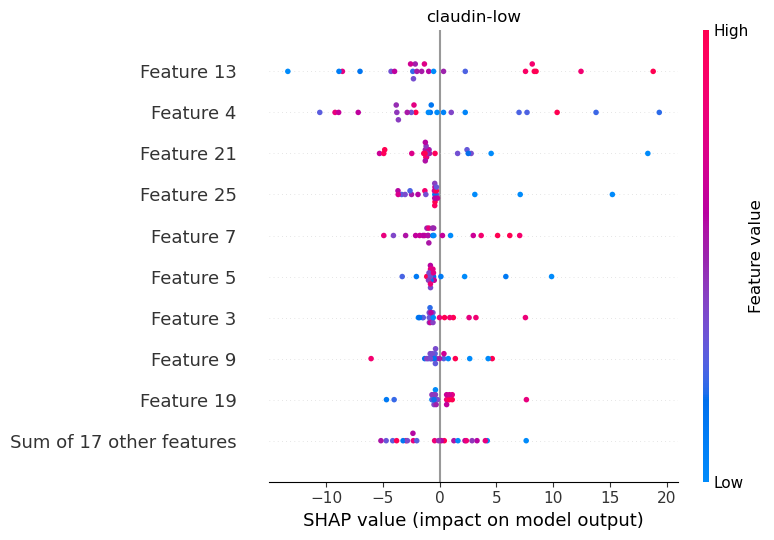

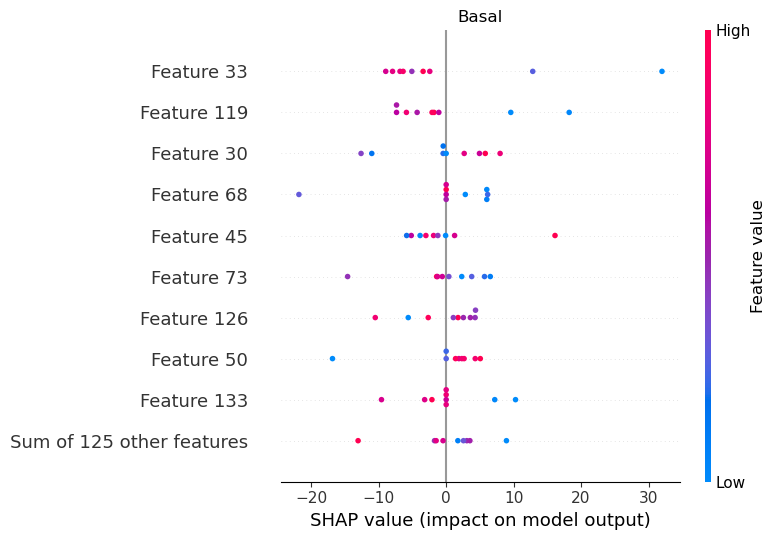

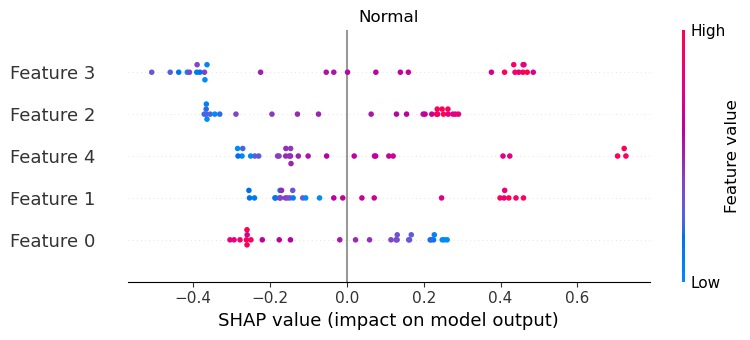

In [260]:
# 

model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca18",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca216",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca51",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca26",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": SurvivalTree().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca134",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "NEWpreprocess4numeric_Incpca5",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


In [168]:
rank_Her2_late2

,shap abs means
Feature 0,0.456976
Feature 1,0.035801
Feature 2,0.031306
Feature 3,0.018177
Feature 4,0.150138
Feature 5,0.457411
Feature 6,0.323454
Feature 7,0.107366
Feature 8,0.081683
Feature 9,0.174749


In [274]:
rank_LumB_late

,gene name,score
0,INTS14,16.090656
1,TRAPPC13,15.932766
2,NSRP1,15.487377
3,NSF,15.364517
4,DPAGT1,15.361634
...,...,...
20598,KLK14,4.064869
20599,EDC3,3.945819
20600,MVK,3.902601
20601,SSBP1,3.779973


In [16]:
subgroup_column = "CLAUDIN_SUBTYPE"
subgroup = "Normal"
preprocess_name = "NEWpreprocess4numeric_Incpca5"

subgroup_path = "./{0}/{1}/{2}".format(
    subgroup_column,
    subgroup,
    preprocess_name,
)

pkl_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/test",
    )
preprocess_pipeline = functions.pickle_load(pkl_path + "/preprocess_pipeline.pkl")
pca = preprocess_pipeline[-1]
pca

IncrementalPCA(n_components=5)

In [17]:
loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    ).apply(lambda x: abs(x))
loadings = pd.DataFrame(loadings)
i =1
for i in range(5):
    loadings.rename(index={'incrementalpca'+str(i): 'Feature'+str(i)}, inplace=True)
l = loadings.T
l

,Feature0,Feature1,Feature2,Feature3,Feature4
RERE,0.225252,0.556720,0.188003,0.398186,0.195262
RNF165,0.474414,0.435572,0.001169,0.121368,0.039163
PHF7,0.584930,0.090376,0.032927,0.156142,0.249547
CIDEA,0.156553,0.135129,0.175893,0.005621,0.108315
TENT2,0.510040,0.283079,0.240545,0.228377,0.032761
...,...,...,...,...,...
VPS72,0.151240,0.338224,0.077757,0.156625,0.024051
CSMD3,0.083875,0.098291,0.076680,0.034011,0.113916
CC2D1A,0.364679,0.225807,0.382536,0.009645,0.211541
IGSF9,0.284603,0.042238,0.030020,0.013882,0.087497


In [304]:
l_gene=pd.DataFrame(l["Feature3"].sort_values(ascending=False))
print(subgroup)
l_gene

Normal


,Feature3
ETS1,0.791058
ARPC5,0.764802
LAMB1,0.698327
RAB8B,0.690963
CPNE8,0.687454
...,...
CYP2D7P1,0.000113
GALNT18,0.000105
ZMYM4,0.000083
RORB,0.000050


In [170]:
rank_Her2_late

,gene name,score
0,NRM,0.893889
1,RAP2A,0.883297
2,MELK,0.868540
3,GTF2H3,0.864332
4,JMJD8,0.859067
...,...,...
20598,LOC730755,0.246286
20599,ITK,0.244274
20600,KRTAP2-2,0.244177
20601,RHAG,0.241213


In [171]:
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
df_rank_late = rank_Her2_late.copy()
df_rank_late

,gene_Her2,score_Her2
0,NRM,0.893889
1,RAP2A,0.883297
2,MELK,0.868540
3,GTF2H3,0.864332
4,JMJD8,0.859067
...,...,...
20598,LOC730755,0.246286
20599,ITK,0.244274
20600,KRTAP2-2,0.244177
20601,RHAG,0.241213


In [57]:
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
df_rank_late = rank_Her2_late.copy()
df_rank_late = pd.merge(df_rank_late, rank_Her2_late, right_index=True, left_index=True)
# 一時的な保存
df_rank_late.to_csv("./explain_score_late.csv")
df_rank_late

,gene_Her2_x,score_Her2_x,gene_Her2_y,score_Her2_y
0,NRM,0.893889,NRM,0.893889
1,RAP2A,0.883297,RAP2A,0.883297
2,MELK,0.868540,MELK,0.868540
3,GTF2H3,0.864332,GTF2H3,0.864332
4,JMJD8,0.859067,JMJD8,0.859067
...,...,...,...,...
20598,LOC730755,0.246286,LOC730755,0.246286
20599,ITK,0.244274,ITK,0.244274
20600,KRTAP2-2,0.244177,KRTAP2-2,0.244177
20601,RHAG,0.241213,RHAG,0.241213


In [66]:
preprocess_pipeline = functions.pickle_load(config.INTERIM_PREPROCESSED_RECURRENCE_DIR + "/CLAUDIN_SUBTYPE/Her2/NEWpreprocess4numeric_Incpca51/test_set/test/preprocess_pipeline.pkl"
                                           )
pca = preprocess_pipeline[-1]
df_51_pca5 = pd.DataFrame(
    pca.components_,
    index=pca.get_feature_names_out(),
    columns=df_gene_expressions.columns,
).T["incrementalpca5"].apply(lambda x: abs(x)).sort_values(ascending=False)

df_51_pca5 = pd.DataFrame(df_51_pca5)
df_51_pca5

,incrementalpca5
Hugo_Symbol,
CHD3,3.374913e-02
GPRACR,3.336705e-02
ICAM1,3.230337e-02
C14orf1,3.211059e-02
MDFI,3.183111e-02
...,...
BAD,2.753580e-06
TM2D2,1.692789e-06
CPA6,1.691522e-06


In [68]:
loadings = pd.DataFrame(
        pca.components_ * np.c_[np.sqrt(pca.explained_variance_)],
        index=pca.get_feature_names_out(),
        columns=pca.feature_names_in_,
    ).T["incrementalpca5"].apply(lambda x: abs(x)).sort_values(ascending=False)
loadings = pd.DataFrame(loadings)
loadings

,incrementalpca5
CHD3,0.687823
GPRACR,0.680036
ICAM1,0.658358
C14orf1,0.654428
MDFI,0.648733
...,...
BAD,0.000056
TM2D2,0.000034
CPA6,0.000034
FLJ41455,0.000004


In [13]:
# 修士論文
model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca41",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "claudin-low",
}
rank_claudinlow_late = calc_score4late_recurrences(
    model_order_dict,
)


model_order_dict = {
    "model_name": ExtraSurvivalTrees().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca43",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumA",
}
rank_LumA_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca77",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "LumB",
}
rank_LumB_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca31",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Her2",
}
rank_Her2_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": GradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca30",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Normal",
}
rank_Normal_late = calc_score4late_recurrences(model_order_dict)


model_order_dict = {
    "model_name": ComponentwiseGradientBoostingSurvivalAnalysis().__class__.__name__,
    "preprocess_name": "preprocess4numeric_pca58",
    "subgroup_column": "CLAUDIN_SUBTYPE",
    "subgroup": "Basal",
}
rank_Basal_late = calc_score4late_recurrences(model_order_dict)

....................................................................................................
model_order_dict name:  GradientBoostingSurvivalAnalysis
input data path:  ./../data/interim/PREPROCESSED/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/test_set/late_recurrences
input pipe path:  ./../data/interim/MODELS/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/GradientBoostingSurvivalAnalysis/test_set
output file path ./../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/GradientBoostingSurvivalAnalysis/test_set/late_recurrences
preprocess or pipeline pkl file dose not exist


FileNotFoundError: [Errno 2] No such file or directory: './../data/interim/EXPLAIN/RECURRENCE/./CLAUDIN_SUBTYPE/claudin-low/preprocess4numeric_pca41/GradientBoostingSurvivalAnalysis/test_set/late_recurrences/shap_values.pkl'

In [14]:
rank_claudinlow_late = rank_claudinlow_late.rename(
    columns={"gene name": "gene_claudin-low", "score": "score_claudin-low"}
)
rank_LumA_late = rank_LumA_late.rename(
    columns={"gene name": "gene_LumA", "score": "score_LumA"}
)
rank_LumB_late = rank_LumB_late.rename(
    columns={"gene name": "gene_LumB", "score": "score_LumB"}
)
rank_Her2_late = rank_Her2_late.rename(
    columns={"gene name": "gene_Her2", "score": "score_Her2"}
)
rank_Basal_late = rank_Basal_late.rename(
    columns={"gene name": "gene_Basal", "score": "Basal"}
)
rank_Normal_late = rank_Normal_late.rename(
    columns={"gene name": "gene_Normal", "score": "score_Normal"}
)

df_rank_late = rank_claudinlow_late.copy()
df_rank_late = pd.merge(df_rank_late, rank_LumA_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_LumB_late, right_index=True, left_index=True)
df_rank_late = pd.merge(df_rank_late, rank_Her2_late, right_index=True, left_index=True)
df_rank_late = pd.merge(
    df_rank_late, rank_Normal_late, right_index=True, left_index=True
)
df_rank_late = pd.merge(
    df_rank_late, rank_Basal_late, right_index=True, left_index=True
)
# 一時的な保存
df_rank_late.to_csv("./explain_score_late.csv")
df_rank_late

NameError: name 'rank_claudinlow_late' is not defined

In [15]:
df_rank

NameError: name 'df_rank' is not defined

In [ ]:
df_rank_late

In [ ]:
# 層別化する特徴量
def exec_shap4late_recurrences(model_order_dict: dict()):
    drop_columns = [
        "CLAUDIN_SUBTYPE",
        "THREEGENE",
    ]

    print(".........." * 10)
    print("model_order_dict name: ", model_order_dict["model_name"])

    subgroup_path = "./{0}/{1}/{2}".format(
        model_order_dict["subgroup_column"],
        model_order_dict["subgroup"],
        model_order_dict["preprocess_name"],
    )
    input_data_path = "./{0}/{1}/{2}".format(
        config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
        subgroup_path,
        "test_set/late_recurrences",
    )
    input_pipe_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_MODELS_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set",
    )
    output_file_path = "./{0}/{1}/{2}/{3}".format(
        config.INTERIM_EXPLAIN_RECURRENCE_DIR,
        subgroup_path,
        model_order_dict["model_name"],
        "test_set/late_recurrences",
    )
    print("input data path: ", input_data_path)
    print("input pipe path: ", input_pipe_path)
    print("output file path", output_file_path)
    explain_model(
        input_data_path=input_data_path,
        input_pipe_path=input_pipe_path,
        output_file_path=output_file_path,
    )

In [ ]:
def explain_model3(
    input_data_path: str = None,
    input_pipe_path: str = None,
    output_file_path: str = None,
):
    # 学習データ・学習済みパイプラインの読み込み
    try:
        _X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
        _y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
        _model_pipeline = functions.pickle_load(
            "{0}/model_pipeline.pkl".format(input_pipe_path)
        )
        _estimator = _model_pipeline[-1]
    except:
        print("preprocess or pipeline pkl file dose not exist")
        return

    # load JS visualization code to notebook
    shap.initjs()

    # explain the model's predictions using SHAP values
    explainer = shap.explainers.Permutation(
        _estimator.predict, _X, max_evals="auto", seed=config.SEED
    )
    """
    explainer = shap.Explainer(
        _estimator.predict,
        _X,
        seed=config.SEED,
    )"""
    shap_values = explainer(_X)
    # shap.plots.beeswarm(shap_values)

    if output_file_path:
        save_shap_instances(
            shap_explainer=explainer,
            shap_values=shap_values,
            save_file_path=output_file_path,
        )

In [15]:
# 必要なライブラリをインポート
from survshap import SurvivalModelExplainer, PredictSurvSHAP, ModelSurvSHAP
from sksurv.ensemble import RandomSurvivalForest # または他の生存分析モデル

subgroup_path="CLAUDIN_SUBTYPE/LumB/NEWpreprocess4numeric_Incpca216"

input_data_path = "./{0}/{1}/{2}".format(
    config.INTERIM_PREPROCESSED_RECURRENCE_DIR,
    subgroup_path,
    "test_set/late_recurrences",
)
input_pipe_path = "./{0}/{1}/{2}/{3}".format(
    config.INTERIM_MODELS_RECURRENCE_DIR,
    subgroup_path,
    "SurvivalTree",
    "test_set",
)


_X = pd.read_pickle("{0}/X.pkl".format(input_data_path))
_y = pd.read_pickle("{0}/y.pkl".format(input_data_path)).to_records(index=False)
_model_pipeline = functions.pickle_load(
    "{0}/model_pipeline.pkl".format(input_pipe_path)
)
_estimator = _model_pipeline[-1]
# データを読み込む

# 生存分析モデルを準備する
"""
model = RandomSurvivalForest()
model.fit(X, y)
"""

# Explainerを作成する
explainer = SurvivalModelExplainer(model=_estimator, data=_X, y=_y)

# 1つの観測値に対するSHAP値を計算する
observation_A = _X.iloc[[0]]
survshap_A = PredictSurvSHAP()
survshap_A.fit(explainer=explainer, new_observation=observation_A)
survshap_A.result
survshap_A.plot()

# 複数の観測値に対するSHAP値を計算する
model_survshap = ModelSurvSHAP(calculation_method="treeshap")
model_survshap.fit(explainer=explainer, new_observations=_X)
model_survshap.result
model_survshap.plot_mean_abs_shap_values()
model_survshap.plot_shap_lines_for_all_individuals(variable="variable1")
extracted_survshap = model_survshap.individual_explanations[0] # PredictSurvSHAP object

ImportError: cannot import name '_MissingValues' from 'sklearn.utils._param_validation' (/root/miniconda3/lib/python3.8/site-packages/sklearn/utils/_param_validation.py)

In [3]:
# 必要なライブラリをインポート
from survshap import SurvivalModelExplainer, PredictSurvSHAP, ModelSurvSHAP
from sksurv.ensemble import RandomSurvivalForest # または他の生存分析モデル

# データを読み込む
X, y = ...

# 生存分析モデルを準備する
model = RandomSurvivalForest()
model.fit(X, y)

# Explainerを作成する
explainer = SurvivalModelExplainer(model=model, data=X, y=y)

# 1つの観測値に対するSHAP値を計算する
observation_A = X.iloc[[0]]
survshap_A = PredictSurvSHAP()
survshap_A.fit(explainer=explainer, new_observation=observation_A)
survshap_A.result
survshap_A.plot()

# 複数の観測値に対するSHAP値を計算する
model_survshap = ModelSurvSHAP(calculation_method="treeshap")
model_survshap.fit(explainer=explainer, new_observations=X)
model_survshap.result
model_survshap.plot_mean_abs_shap_values()
model_survshap.plot_shap_lines_for_all_individuals(variable="variable1")
extracted_survshap = model_survshap.individual_explanations[0] # PredictSurvSHAP object


TypeError: cannot unpack non-iterable ellipsis object